# HIV Methylation Age: Benchmarking Models

### Imports and Helper Functions

In [1]:
import os 
if os.getcwd().endswith('Benchmarks'):
    os.chdir('..')

In [2]:
import NotebookImport
from Setup.Imports import *

importing IPython notebook from Setup/Imports

Populating the interactive namespace from numpy and matplotlib


In [3]:
from Setup.MethylationAgeModels import run_horvath_model, run_hannum_model

importing IPython notebook from Setup/MethylationAgeModels

In [4]:
from Setup.Read_HIV_Data import *

importing IPython notebook from Setup/Read_HIV_Data

### Read in Datasets

In [5]:
df_meth = pd.read_hdf('/data_ssd/methylation_norm.h5', 'quant_BMIQ_adj')

In [6]:
store = pd.HDFStore('/data_ssd/methylation_norm.h5')

In [7]:
labels = store['labels']
labels = labels.set_index('sampleNames')['studyIndex']

In [8]:
df_meth_n = pd.read_hdf('/data_ssd/methylation_norm.h5', 'BMIQ_Horvath')

n2 = flow_sorted_data.groupby(cell_type, axis=1).mean()
avg = n2[cell_counts.columns].dot(cell_counts.ix[df_meth_n.columns].T)
d2 = df_meth_n.ix[avg.index, df_meth_n.columns].dropna(axis=[0,1], how='all')
cc = avg.mean(1)
df_meth_n = (d2 - avg).add(cc, axis=0).dropna(how='all')

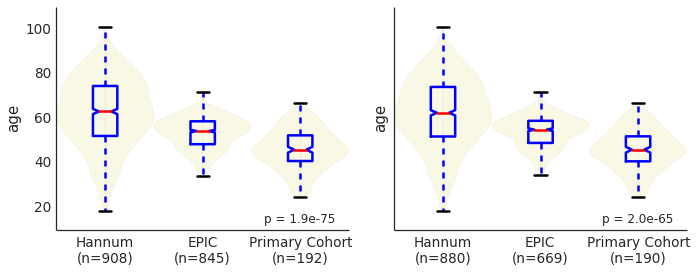

In [9]:
fig, axs = subplots(1,2, figsize=(10,4), sharey=True)
l2 = labels.map({'s1':'Hannum','s3':'EPIC','s2':'Primary Cohort'})
violin_plot_pandas(l2, age, ax=axs[0])
violin_plot_pandas(l2.ix[study.index], age, ax=axs[1])
for ax in axs:
    prettify_ax(ax)
    ax.set_xlabel('')
fig.tight_layout()

## Run Age Predictions

In [10]:
pred = run_hannum_model(df_meth)
pred_horvath = run_horvath_model(df_meth_n)
pred_c = (pred_horvath + pred) / 2
pred_c.name = 'Predicted Age (Combined)'

All Patients

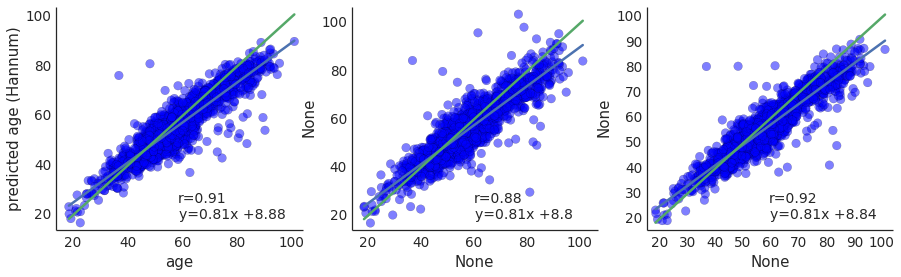

In [11]:
fig, axs = subplots(1,3, figsize=(15,4))

pts = labels.ix[labels != 's2'].index
plot_regression(age.ix[pts], pred, ax=axs[0])
plot_regression(age.ix[pts], pred_horvath.ix[pred.index], ax=axs[1])
plot_regression(age.ix[pts], pred_c.ix[pred.index], ax=axs[2])

In [12]:
pts = labels.index.diff(ti(study.isin(['HIV Short','HIV Long'])))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

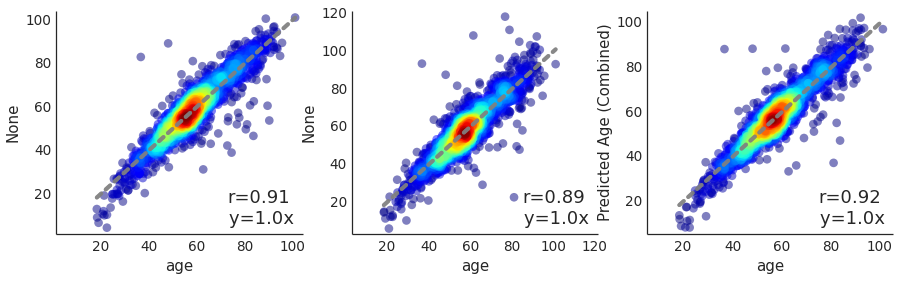

In [13]:
fig, axs = subplots(1,3, figsize=(15,4))
plot_regression(age, m1_adj, ax=axs[0], density=True)
plot_regression(age, m2_adj, ax=axs[1], density=True)
plot_regression(age, mc_adj, ax=axs[2], density=True)

Only Hannum Data 
* Both used this in training 
* This was the full training set for Hannum, a subset for Horvath

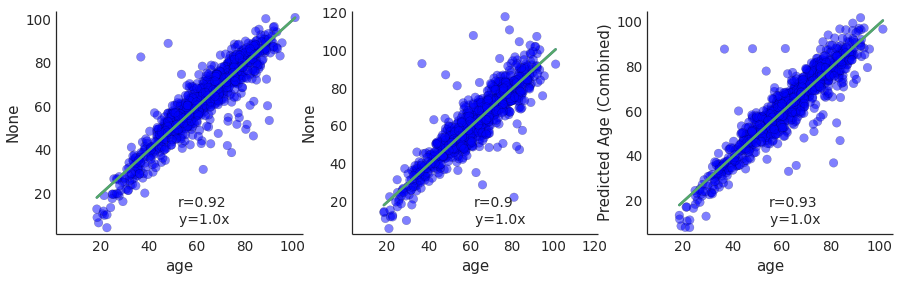

In [14]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s1')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s1')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s1')], mc_adj, ax=axs[2])

EPIC Data 
* Not used in training for either study

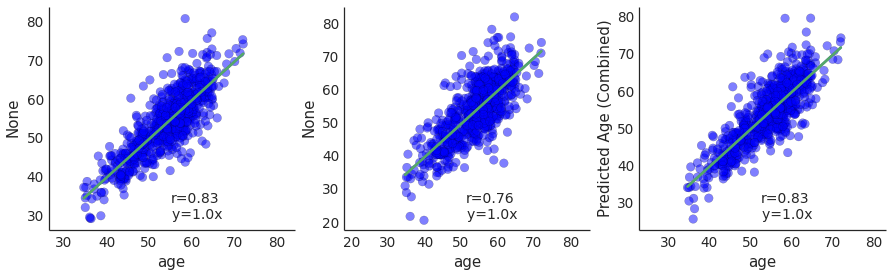

In [15]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s3')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s3')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s3')], mc_adj, ax=axs[2])

Control samples from our current study

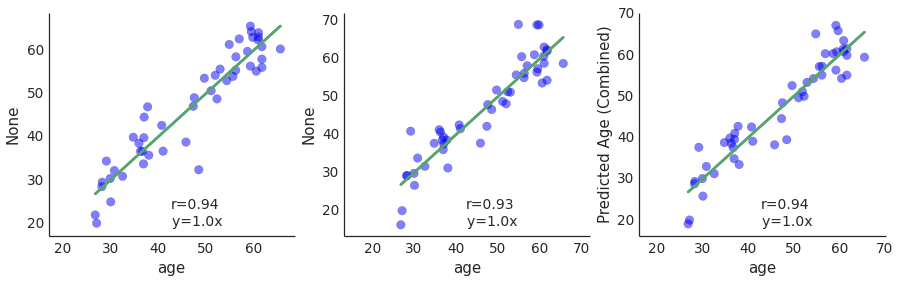

In [16]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s2')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s2')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s2')], mc_adj, ax=axs[2])

In [17]:
dd = pd.DataFrame({(s, m.name): model_fit(m.ix[ti(l2 == s)], age) for s in l2.unique()
                  for m in [m1_adj, m2_adj, mc_adj]})
dd = dd.unstack().unstack(1).T
dd

ValueError: Index contains duplicate entries, cannot reshape

Long term HIV infected patients

## Limit to Set of Patients Being Studied

* Males
* Between 25-68 years old

In [ ]:
in_set = pd.Series(pred.index.isin(study.index), pred.index)
in_set = in_set.ix[in_set.index.diff(ti(study.isin(['HIV Short','HIV Long']) == True))]

In [ ]:
in_set.value_counts()

Looking at the diffence in age advancement from the patients in the set to those withheld.

In [ ]:
pts = in_set.index
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

In [ ]:
fig, axs = subplots(1,3, figsize=(15,4), sharey=True)
violin_plot_pandas(in_set, (m1_adj - age) / age, ax=axs[0])
violin_plot_pandas(in_set, (m2_adj - age) / age, ax=axs[1])
violin_plot_pandas(in_set, (mc_adj - age) / age, ax=axs[2])
for ax in axs:
    prettify_ax(ax)
    ax.set_ylabel('Age Advancement')

In [ ]:
pts = ti(in_set)
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

In [ ]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age.ix[ti(labels=='s3')], m1_adj, ax=axs[0])
plot_regression(age.ix[ti(labels=='s3')], m2_adj, ax=axs[1])
plot_regression(age.ix[ti(labels=='s3')], mc_adj, ax=axs[2])

In [ ]:
pts = ti(in_set).diff(ti(labels == 's2'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

In [ ]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0])
plot_regression(age, m2_adj, ax=axs[1])
plot_regression(age, mc_adj, ax=axs[2])

## Patients Not in Study Set

All Patients

In [ ]:
pts = ti(in_set == False).diff(ti(labels == 's2'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

In [ ]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0])
plot_regression(age, m2_adj, ax=axs[1])
plot_regression(age, mc_adj, ax=axs[2])

Females 25-68

In [ ]:
pts = ti((age >= 25.) & (age <= 68.) & (gender == 'F'))
m1_adj, m2_adj, mc_adj = two_step_adjustment(pred, pred_horvath, age, labels.ix[pts])

In [ ]:
fig, axs = subplots(1,3, figsize=(15,4))

plot_regression(age, m1_adj, ax=axs[0], density=True)
plot_regression(age, m2_adj, ax=axs[1], density=True)
plot_regression(age, mc_adj, ax=axs[2], density=True)